# Using the CHIMERA code for FEL and laser plasma simulations

by Igor A Andriyash (<igor.andriyash@gmail.com>)

CHIMERA is a relativistic electromagnetic particle-in-cell code, based on a quasi-cylindric pseudo-spectral analitical time domain (PSATD) Maxwell solver. 

System requirements
- code runs under Linux or MacOS
- Fortran 90/95 compiler with OpenMP support (e.g. recent gfortran or ifort)
- Python with NumPy, SciPy; Additionally Matplotlib, Ipython and Jypyter are recommended
- FFTW3 (http://www.fftw.org), better to be compiled with the same compiler and "-fPIC" option enabled

To install CHIMERA
- clone the code folder to your working directory and add it to the PYTHONPATH
- Check that Makefile contains a correct address to FFTW3 /lib/ and /bin/
- compile the Fortran modules using *make*. 

To run CHIMERA in multiprocessor mode specify the OMP_NUM_THREADS variable. For the present demo OMP_NUM_THREADS=4 was used.

## Importing the code and some utilities

- the Specie class defines a marco-particle specie
- the Solver class defines a quasi-cylindrical PSATD Maxwell solver
- the ChimeraRun manages the simulations runtime with number of marco-particle species, solvers and moving windows
- the Diagnostics has utilities to return or damp particles and fields from the ChimeraRun
- module "fimera" contains the Fortran subroutines used by the code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import sys, time

from chimera.moduls.species import Specie
from chimera.moduls.solvers import Solver
from chimera.moduls.chimera_main import ChimeraRun
from chimera.moduls.diagnostics import Diagnostics
import chimera.moduls.fimera as chimera

# FEL simulation

Let us define a simple FEL simulation. We will model propagation of a cylindrical 20 pC electron beam propagating at energy $\varepsilon_b=200$ MeV in a 300 period long undulator with a field period of 28 mm and strength $K_0 = 1.95$. Beam has the dimensions $L_x$ = $R$ = 80 $\mu$m, energy spread of 0.01% and the transverse divergence 20 $\mu$rad.

## Defining the physical simulation parameters

All lengths will be in the undulator period length, $\lambda_u$, time in $\lambda_u/c$, and particles density is normailzed to its critical value $n_c = (\lambda_u \mathrm{[\mu m]})^{-2}  \cdot 1.1\cdot 10^{21}\; \mathrm{[cm]}^{-3}$. 

### Undulator

In [2]:
K0 = 1.95
Periods = 350
lam0 = 2.8

### Electron beam

In [3]:
g0 = 200/0.511
lbx  = 80e-4/lam0
lbr  = 80e-4/lam0
dens = 20e-12/1.6022e-19/(np.pi*80e-4**3)/(1.1e21/2.8e4**2)

### FEL resonance and beam propagation speed

These values will be needed to tune the wave-number shift in solver and co-propagating frame speed.

In [4]:
gg = g0/(1.+K0**2/2)**.5
k_res = 2*gg**2
vb = (1.-gg**-2)**0.5

### Simulation grid and time step


The simulation grid should be significantly bigger than the beam, and should resolve its size with at least several cells radially and several tens of cells longitudinally. 

A radially cut grid can be considered for particles, in order to reduce computational load -- in this case particles interact with the grid till this cut (Rg_cut in following script), and the full grid radius will provide the reflecting boundary conditions. 

The time step should well resolve the particles motion in the undulator -- at least with 30 steps per period

In [5]:
Lgx  = 200e-4  /lam0
Rg   = 1000e-4  /lam0
Rg_cut = 700e-4/lam0
Nx,Nr = 120,120

dt = 1./30
SimulationSteps = int(Periods/dt)

## Constructing the simulation objects

To run the simulation one needs to construct the beam, the solver and the simulation runtime

### Solver

The argument for the solver constructor should contain the Grid defined as ($x_{min}$,$x_{max}$,$R$, $\Delta x$, $\Delta R$), the time step and the maximal mode index for the angular Fourier decomposition. 

Additionally for the FEL simulation, we shift the spectral domain to the resonant wave-number, add the R-cut of the grid, precise the beam mean velocity to tune the numerical slippage (if not, $c$ is assumed, which if also fine). Finally, we let solver know that particles on grid will be longitudinally divided into 4 chuncks for parallel computation.

To seed the FEL we add a radiation beam of a Gaussian shape, $a=a_0 \exp(-x^2/\sigma_x^2-r^2/w_0^2)$, with resonant wavelength, with $\sigma_x$ = 15 $\mu$m, $w_0$ = 100 $\mu$m, which is placed initially at the tail of the electron beam $x_0$ = -30 $\mu$m, and is focused at 70 cm from undulator entrance.

In [6]:
solver_in = {
    'Grid':(-0.5*Lgx, 0.5*Lgx, Rg, Lgx/Nx, Rg/Nr), 
    'TimeStep':dt, 'MaxAzimuthMode':0, 
    'KxShift':k_res,'Rcut':Rg_cut ,
    'CoPropagative':vb, 'Xchunked':(4,6),
    'Features':{'NoPoissonCorrection':True,},
}

seed_in = {
    'a0':0.15,'k0':k_res,'x0':-30e-4/lam0,
    'x_foc':70.0/lam0,'Lx':15e-4/lam0,'LR':180e-4/lam0
}

solver = Solver(solver_in)
solver.add_gauss_beam(seed_in)

Constructing solver with cylindric boundaries:
** left=-0.00351, right=0.00357, radius=0.0359
Spatial and temporal resolutions:
** dx=5.95e-05, dr=0.000298, dt=0.0333
Solver is active from t=0 to t=inf
Grid sizes are:
** Nx=120, Nr=120, Mo=1
Spectral domain is shifted
Rgrid is cut after 0.024851 (Nr is reduced to 85)
Echo suppression is actived (expert feature)
** To change, set 'AntiEchoStrength' in solvers 'Features',
** or add 'NoAntiEcho' to solvers 'Features' to disactivate
**** 13-th grid echo at -0.5714 correcting with strength 2
**** 14-th grid echo at 0.4286 correcting with strength 2
Poisson correction will not be performed


### Electron beam

The argument for the specie constructor should contain the Grid defined as ($x_{min}$,$x_{max}$,$R$, $\Delta x$, $\Delta R$), the time step, the species charge and mass in positron units. In the parallel computation particles on grid can be longitudinally divided into chuncks -- in this case solver and specie lingitudinal grids must be identical.

If the specie is to be created by CHIMERA (otherwise should be exported), their maximal density and number per cell should be defined -- either as RandCell = Nppc, for pseudo-random distribution, or FixedCell = (Nx,Nr,No) for uniform distribution (rotation angle of each cell is randomized in this case). The MomentaMeans and MomentaSpreads should be added for the beam definition -- otherwise they are zeros. 

The particles are generated by Specie.gen_parts and added by Specie.add_particles methods. The particle generator arguments can be:
- Domain=($x_{min}$,$x_{max}$,$R_{min}$,$R_{max}$) or Xsteps = N -- to create particles in N rightmost cells
- ProfileFunc = f(x) or f(x,y,z) a density distribution 
- if no argument is specified total grid is uniformly populated.

The external fields (e.g. undulators, pulses, lattice elements) can be added to the species as Devices -- there are few predefined in chimera fortran module. Here we add a planar undulator with $\lambda_u$-long entrance and exit ramps.

The shot-noise can be suppressed using Specie.denoise method, which takes a list of wavenumbers to treat (each wavenumber increases number of macroparticles by $\times 2$)

In [7]:
beam_in = {
    'Grid':(-0.5*Lgx, 0.5*Lgx, Rg, Lgx/Nx, lbr/Nr),'TimeStep':dt,'Charge':-1.,'Mass':1.,
    'Density':dens, 'RandCell':50,'MomentaMeans':(g0,0.,0.), 'MomentaSpreads':(1e-4*g0,2e-5*g0,2e-5*g0),
    'Xchunked':(4,6),
}

beam_in['Devices'] = ([chimera.undul_analytic,np.array([K0, 1., 1., Periods])],)

beam = Specie(beam_in)
beam.add_particles(*beam.gen_parts(Domain=(-0.5*lbx, 0.5*lbx, 0.0, lbr)))
beam.denoise((k_res,))

## Constructing the simulation

In most of CHIMERA simulations (FEL and LPA), the co-propagating frame is used. One or more frames be added to the simulation giving each time step, velocity, cycling frequency (in simulation steps). As the other code objects, MovingFrame take the Features argument, and for FEL simulation it should be 'Staged' and NoSorting should be specified to avoid particle sorting at each time step.

The simulation runtime object of ChimeraRun class is constructed for given solver, specie, and frame.

In [8]:
MovingFrame = {
    'TimeStep':dt,'Steps':1,'Velocity':vb,'Features':('Staged','NoSorting')
}

chimera_in = {'Solvers':(solver,),'Particles':(beam,),'MovingFrames':(MovingFrame,)}
Chimera = ChimeraRun(chimera_in)

Diags = Diagnostics(Chimera)

# Running the simulation

In [9]:
diag_step = int(1./dt)
nrg = Diags.nrg_out({'Features':('Return',)})[0]
pwr = Diags.pwr_out({'Features':('Return',)})[0]

diag_nrg = np.zeros((int(SimulationSteps/diag_step)+1,nrg.shape[0]))
diag_pwr = np.zeros((int(SimulationSteps/diag_step)+1,pwr.shape[0]))

diag_nrg[0] = nrg
diag_pwr[0] = pwr

for i in range(1,SimulationSteps+1):
    Chimera.make_step(i)
    sys.stdout.write('\r'+str(i)+'/'+str(SimulationSteps))
    sys.stdout.flush()
    if np.mod(i,diag_step)==0:
        diag_nrg[int(i/diag_step)] = Diags.nrg_out({'Features':('Return',)})[0]
        diag_pwr[int(i/diag_step)] = Diags.pwr_out({'Features':('Return',)})[0]

10500/10500

## Examples of output data plots

### Radiation data

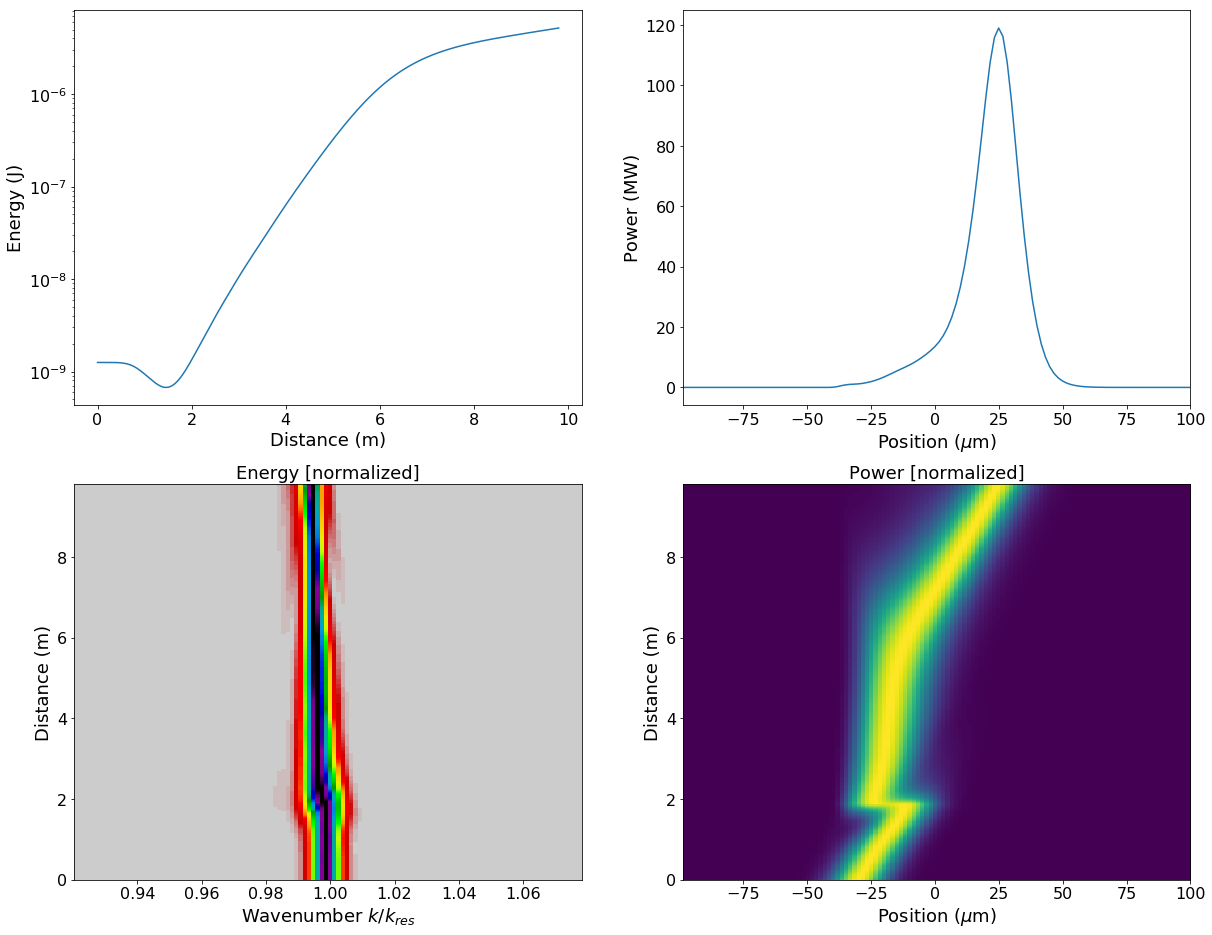

In [10]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,16))

s_full = Periods*lam0*vb*1e-2
z0 = s_full*1e6

kmin,kmax = solver.Args['kx'].min()/(2*np.pi),solver.Args['kx'].max()/(2*np.pi)
xmin,xmax = beam.Args['Xgrid'].min()*lam0*1e4-z0, beam.Args['Xgrid'].max()*lam0*1e4-z0

Xgrid_init = beam.Args['Xgrid']-Periods*vb

ax1.semilogy(np.arange(diag_nrg.shape[0])*diag_step*dt*lam0*1e-2, diag_nrg.sum(-1)*lam0)
ax2.plot(Xgrid_init*lam0*1e4, diag_pwr[-1]*1e-6)
ax2.set_xlim(xmin,xmax)

ax3.imshow(diag_nrg/diag_nrg.max(-1)[:,None],aspect='auto',origin='lower',cmap=plt.cm.spectral_r,
           extent=(kmin/k_res,kmax/k_res,0,s_full))
ax4.imshow(diag_pwr/diag_pwr.max(-1)[:,None],aspect='auto',origin='lower',
           extent=(xmin,xmax,0,s_full))

ax1.set_xlabel('Distance (m)',fontsize=18)
ax2.set_xlabel('Position ($\mu$m)',fontsize=18)

ax1.set_ylabel('Energy (J)',fontsize=18)
ax2.set_ylabel('Power (MW)',fontsize=18)

ax3.set_xlabel('Wavenumber $k/k_{res}$',fontsize=18)
ax4.set_xlabel('Position ($\mu$m)',fontsize=18)
for ax in [ax3, ax4]: ax.set_ylabel('Distance (m)',fontsize=18)

for ax in [ax1, ax2, ax3, ax4]: 
    for coord in [ax.xaxis,ax.yaxis]:
        for tick in coord.get_major_ticks(): tick.label.set_fontsize(16)
            
ax3.set_title('Energy [normalized]',fontsize=18);
ax4.set_title('Power [normalized]',fontsize=18);

### Particles data

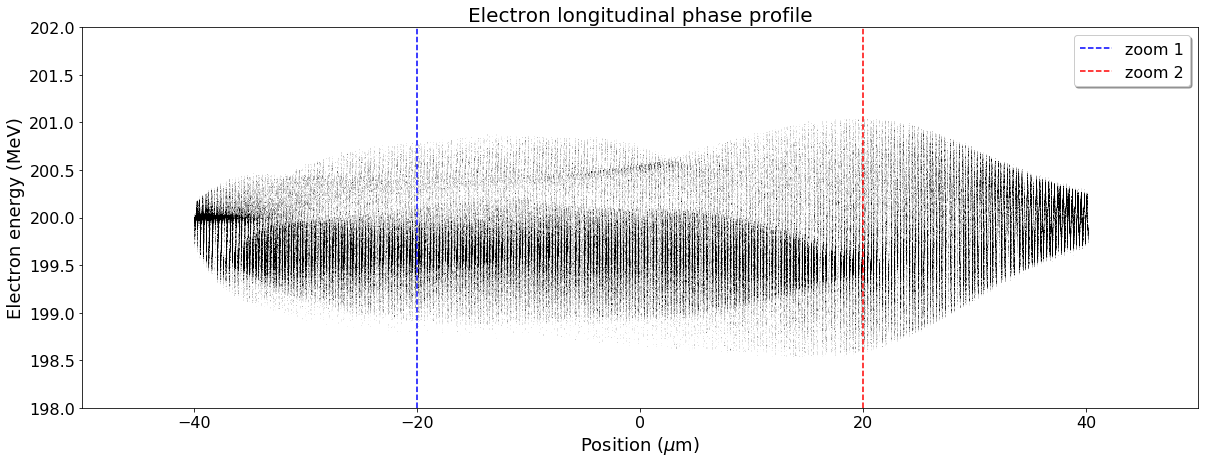

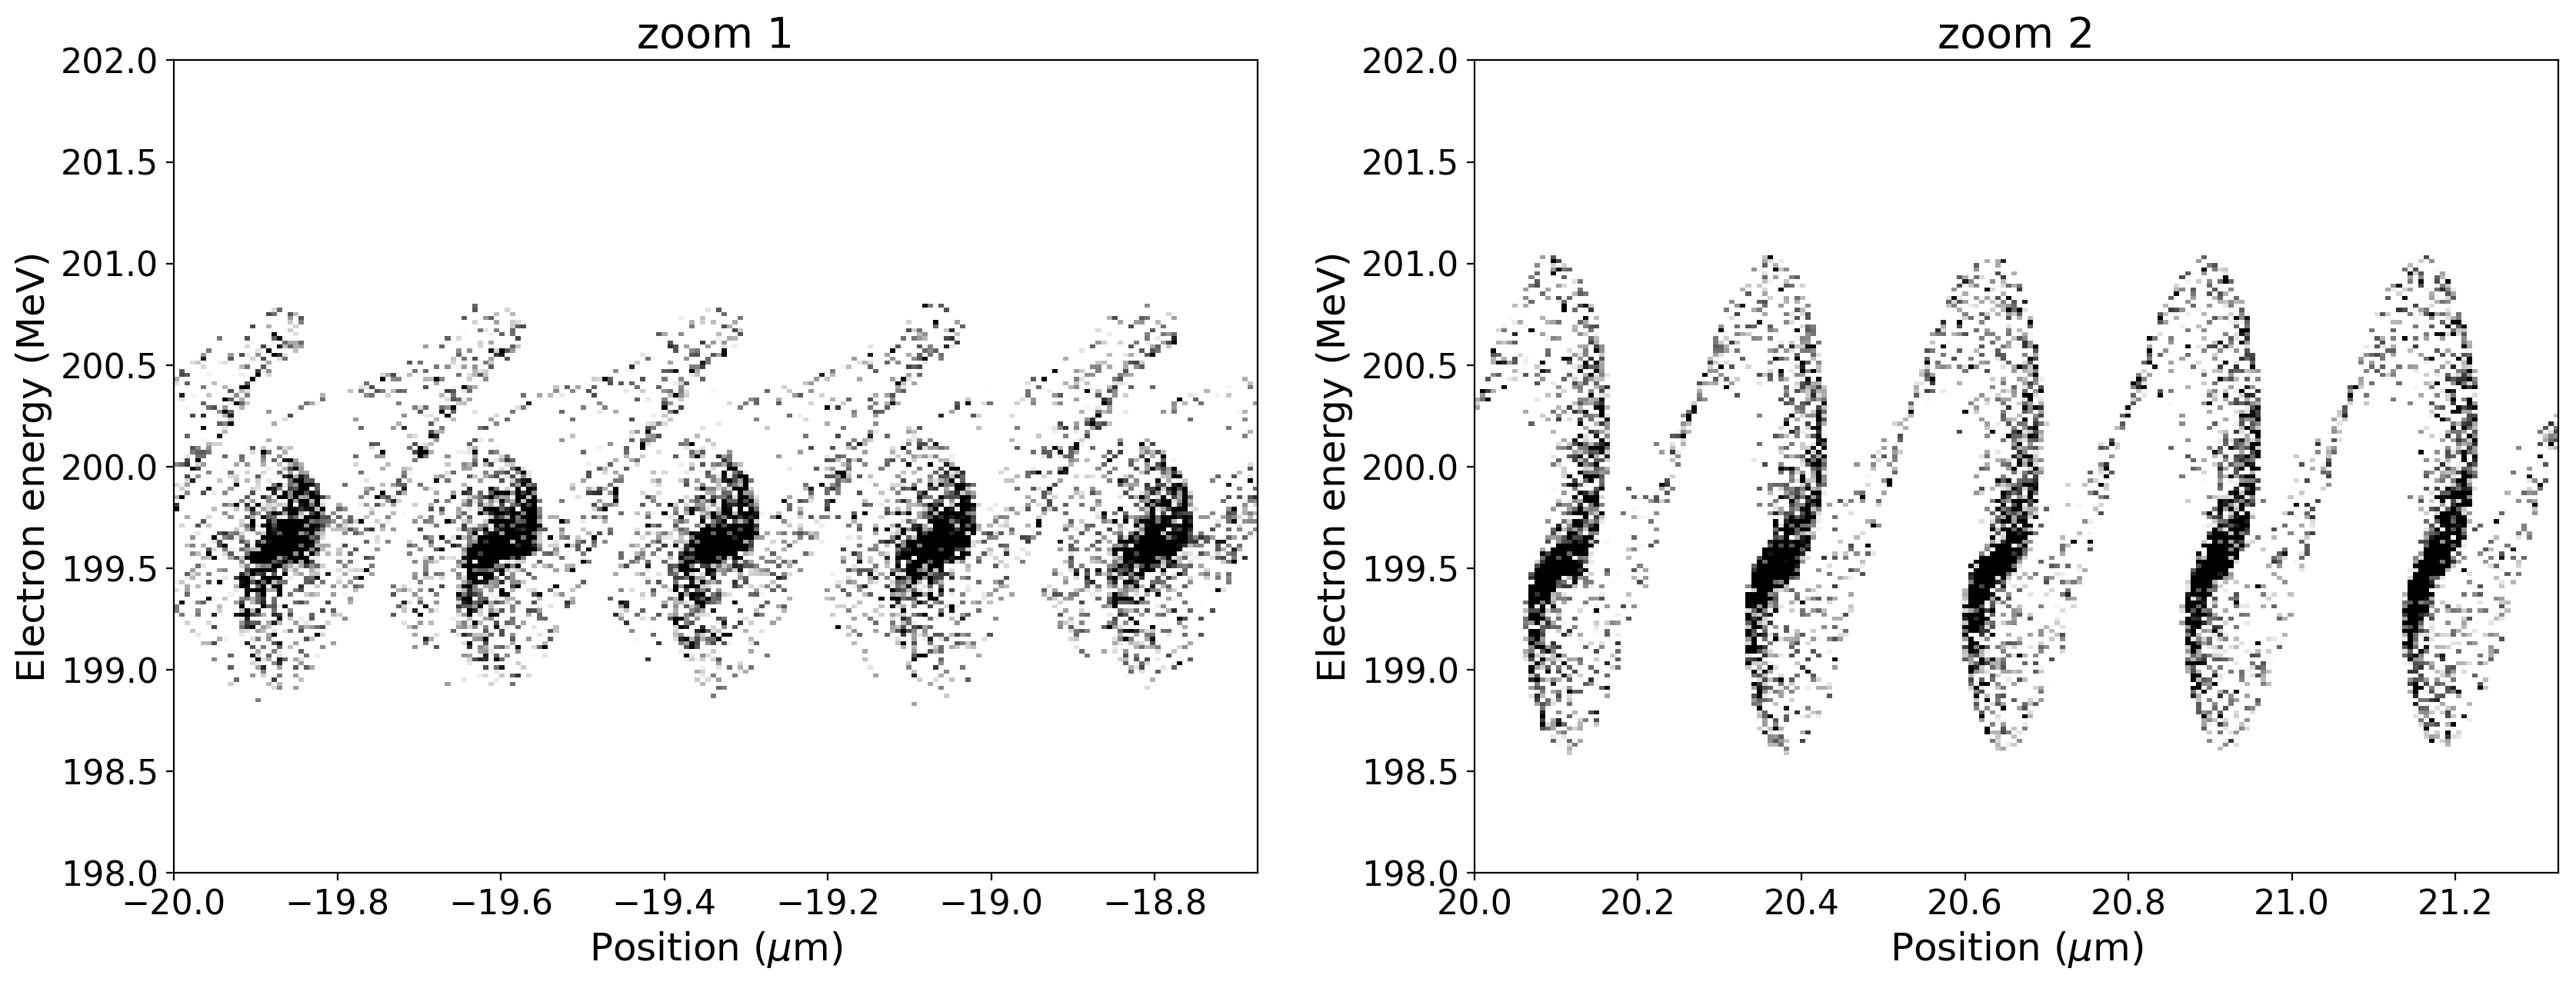

In [11]:
fig0, ax0 = plt.subplots(1,1,figsize=(20,7))

ax0.hist2d(beam.Data['coords'][0]*lam0*1e4-z0,beam.Data['momenta'][0]*0.511,
           weights=beam.Data['weights'],bins=(1000,200),cmap=plt.cm.gray,vmin=-1e-10);
ax0.set_xlim(-50,50)
ax0.set_ylim(198,202)

fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(20,7),dpi=200)

ax1.hist2d(beam.Data['coords'][0]*lam0*1e4-z0,beam.Data['momenta'][0]*0.511,
           weights=beam.Data['weights'],bins=(200,200),cmap=plt.cm.gray,
           vmin=-0.2e-10,range=[[-20,-20+5*lam0*1e4/k_res],[198,202]]);
ax2.hist2d(beam.Data['coords'][0]*lam0*1e4-z0,beam.Data['momenta'][0]*0.511,
           weights=beam.Data['weights'],bins=(200,200),cmap=plt.cm.gray,
           vmin=-0.2e-10,range=[[20,20+5*lam0*1e4/k_res],[198,202]]);

ax0.plot(-20*np.ones(100), np.r_[198:202:100j],'--',c='b',lw=1.5)
ax0.plot(20*np.ones(100), np.r_[198:202:100j],'--',c='r',lw=1.5)


for ax in [ax0,ax1,ax2]: 
    ax.set_xlabel('Position ($\mu$m)',fontsize=18)
    ax.set_ylabel('Electron energy (MeV)',fontsize=18)
                  
for ax in [ax0,ax1,ax2]: 
    for coord in [ax.xaxis,ax.yaxis]:
        for tick in coord.get_major_ticks(): tick.label.set_fontsize(16)
            
ax0.set_title('Electron longitudinal phase profile',fontsize=20);
ax0.legend(('zoom 1','zoom 2',),fontsize=16,fancybox=True,shadow=True);
ax1.set_title('zoom 1',fontsize=20);
ax2.set_title('zoom 2',fontsize=20);

# Laser plasma interaction (acceleration)

As a simplest example of laser plasma interaction we model propagation of a short, 13.3 fs, laser pulse tightly focused  to a waist of 4 $\mu$m in an underdense plasma. Plasma density has a linear ramp 40 $\mu$m, where it reaches values of $n_{max} = 0.005 n_c$, and which is followed by a shap fall over 10 $\mu$m till $0.5 n_{max}$, and then it remains constant. Maximal laser strength is set to $a_0=3$ and focuse is places at 45 $\mu$m.

## Defining the physical simulation parameters

All lengths will be in the laser wavelength, $\lambda_0$ = 1 $\mu$m, time in $\lambda_0/c$, and particles density is normailzed to its critical value. 

### Simulation grid and time step


We wil start with the laser in an empty simulation box, and the frame will be moving to the right towards the plasma.

The simulation grid should be enough big than contain the laser beam, and should resolve laser wavelength with at least few tens of cells longitudinally.

The time step should resolve the plasma wave propagation and for convenience it can be chosen to be equal to the cell size (this way it easier complies with the moving frame)

In [2]:
xgmin, xgmax = -50., 1.
Rg = 16.0

dx = 0.04
dr = 0.25
dt = dx

SimulationSteps = 3000

### Laser

In [3]:
a0 = 3.
Lx = 4.
w0 = 4.
x_foc = 45.
x0 = -14.

### Electron-proton plasma

Here we define a plasma density profile with a simple function

In [4]:
dens = 0.005
densprof = lambda x: np.interp(x, [0.,40.,50.,300],[0.,1.,0.5,0.5])

## Constructing the simulation objects

### Solver

To resolve the linearly polarized laser and radial plasma fields at least modes 0 and 1 of are requred for the angular Fourier decomposition. The solver should include a space charge fields, and this should be specified in the solvers Features. For faster simulation, the ions can be treated as immobile (still) particles and be treated only as a background, and this can also be specified in the solver.

Finally, we let solver know that particles on grid will be longitudinally divided into 4 chuncks with 20 guard cells for the  parallel computation.

In [5]:
solver_in = {
    'Grid':(xgmin, xgmax,Rg,dx,dr),'TimeStep':dt, 'MaxAzimuthMode':1,
    'Xchunked':(16,10),'Features':('SpaceCharge','StillAsBackground',)
}

laser_in = {
    'a0':a0,'k0':1.0,'x0':x0,'x_foc':x_foc,'Lx':Lx,'LR':w0
}

solver = Solver(solver_in)
solver.add_gauss_beam(laser_in)

Constructing solver with cylindric boundaries:
** left=-50.2, right=1, radius=16.1
Spatial and temporal resolutions:
** dx=0.04, dr=0.25, dt=0.04
Solver is active from t=0 to t=inf
Grid sizes are:
** Nx=1280, Nr=64, Mo=2
Charge density will be considered
"Still" species will be treated as background


### Electron-proton plasma

The plasma species should be only defined in the beggining, as plasma generation will be handled by the MovingFrame. To reduce the numerical plasma noise the macro-particles should be distributed in cell uniformly, so FixedCell mode should be chosen. In the parallel calculation we sort the particles only when the co-propagative frame is moving, so that cyclewise sorting should be disabled.

Since the protons will be soncided as a background, this should be specified in their Features.

In [6]:
electrons_in = {
    'Grid':(xgmin, xgmax,Rg,dx,dr), 'TimeStep':dt,
    'Density':dens, 'FixedCell':(2,2,4),
    'Xchunked':(16,10),'Features':('NoSorting',)
}

ions_in = deepcopy(electrons_in)
ions_in['Charge'] = 1
ions_in['Mass'] = 1886
ions_in['Features'] += ('Still',)

electrons = Specie(electrons_in)
ions = Specie(ions_in)

## Constructing the simulation

For the plasma simulation, co-propagating frame can be used to create and sort the particles, and to apply field and particles absorption at the left boundary.

In [7]:
MovingFrame = {
    'TimeStep':dt,'Steps':10,'AbsorbLayer':175,'AddPlasma':densprof,'Features':('IonsOnTop',)
}

chimera_in = {
    'Solvers':(solver,),'Particles':(electrons,ions),'MovingFrames':(MovingFrame,)
}

Chimera = ChimeraRun(chimera_in)
Diags = Diagnostics(Chimera)

# Running the simulation

In [8]:
diag_step = int(1./dt)

laser_amplitude = np.zeros(int(SimulationSteps/diag_step)+1)
laser_amplitude[0] = np.real(solver.Data['EB'][:,0,0,2]).max()

for i in range(1,SimulationSteps+1):
    Chimera.make_step(i)
    sys.stdout.write('\r'+str(i)+'/'+str(SimulationSteps))
    sys.stdout.flush()    
    if np.mod(i, diag_step)==0:
        laser_amplitude[int(i/diag_step)] = np.real(solver.Data['EB'][:,0,0,2]).max()

3000/3000

## Examples of output data plots

Beam charge -28.3153 pC, emittanes are 0.214522 and 0.330883 microns


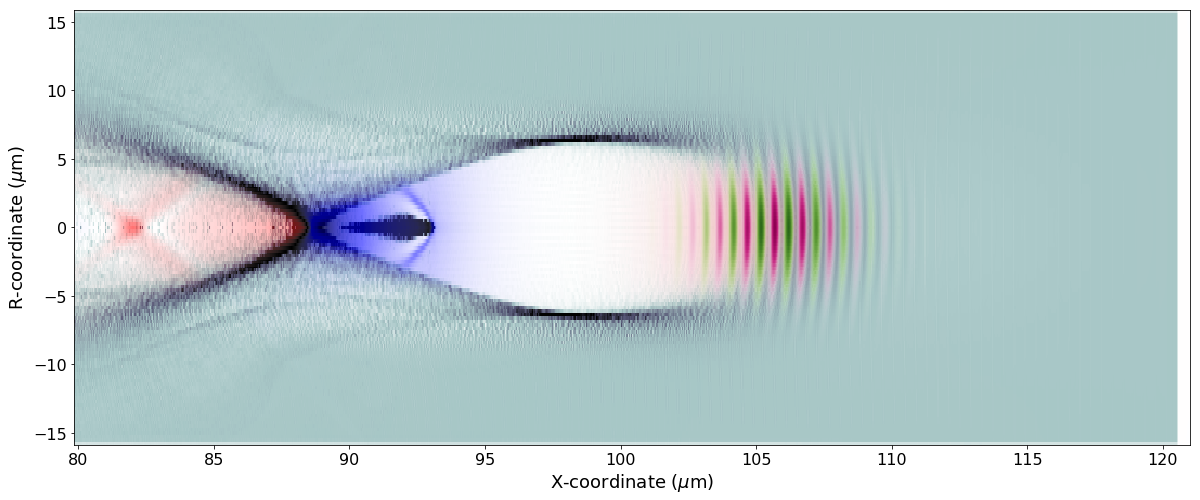

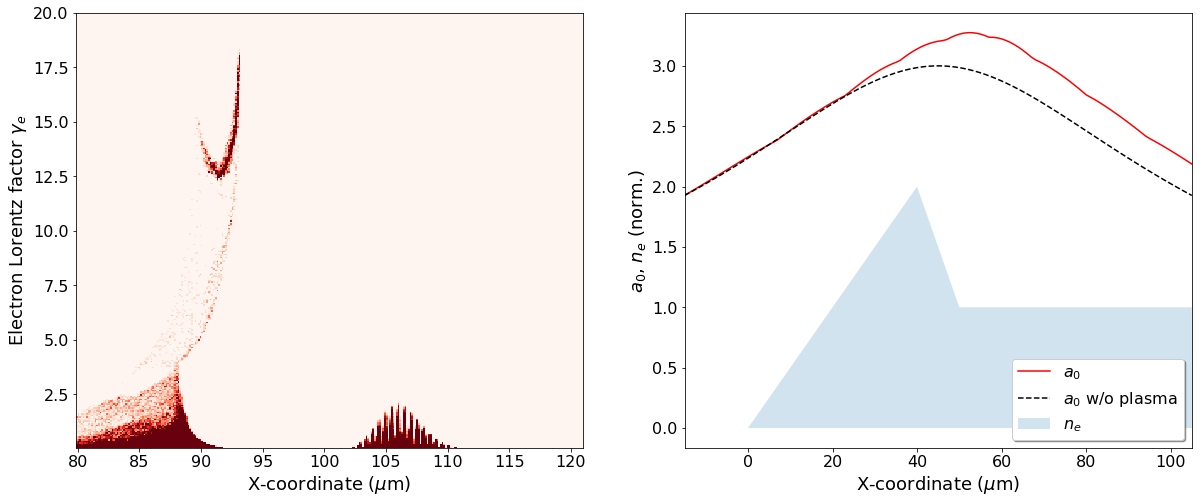

In [9]:
fig0, ax0 = plt.subplots(1,1,figsize=(20,8))
fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

mymap1 = plt.cm.seismic;mymap1._init()
mymap1._lut[:,-1] = 0.8*abs(np.sin(np.r_[-0.5*np.pi:0.5*np.pi:259j]))
mymap2 = plt.cm.PiYG;mymap2._init()
mymap2._lut[:,-1] = abs(np.sin(np.r_[-0.5*np.pi:0.5*np.pi:259j]))**2
extent = (solver.Args['Xgrid'].min(),solver.Args['Xgrid'].max(),
          -solver.Args['Rgrid'].max(),solver.Args['Rgrid'].max())

ne = np.real(Diags.dns_out( {'Features':('Return',)} )[0][:,:,0])
ez = np.real(Diags.fld_out( {'Features':('Return',)} )[0][:,:,0,2])
ex = np.real(Diags.fld_out( {'Features':('Return',)} )[0][:,:,0,0])

ax0.imshow(np.hstack((ne[:,::-1],ne[:,1:])).T ,aspect='auto',cmap=plt.cm.bone,extent=extent,vmin=-2*dens)
ax0.imshow(np.hstack((ex[:,::-1],ex[:,1:])).T ,aspect='auto',cmap=mymap1,extent=extent, 
           vmax = np.abs(ex).max(), vmin = -np.abs(ex).max())
ax0.imshow(np.hstack((ez[:,::-1],ez[:,1:])).T ,aspect='auto',cmap=mymap2,extent=extent,
          vmax = np.abs(ez).max(), vmin = -np.abs(ez).max())

ax0.set_xlim(ax0.get_xlim()[0]+10,ax0.get_xlim()[1])

ax1.hist2d(electrons.Data['coords'][0],electrons.Data['momenta'][0],weights=electrons.Data['weights'],
           bins=300,vmin=-0.0005,cmap=plt.cm.Reds_r,range=[ax0.get_xlim(),[0.05,20]]);

zz = np.arange(laser_amplitude.shape[0])*diag_step*dt-15
ax2.plot(zz, laser_amplitude,lw=1.5,c='r');
ax2.plot(zz, a0/(1+((zz-45)/(np.pi*w0**2))**2)**.5,'--',c='k');
ax2.fill_between(zz, 2*densprof(zz),alpha=0.2);

ax2.legend(('$a_0$','$a_0$ w/o plasma','$n_e$',),fontsize=16,fancybox=True,shadow=True,loc=4);
ax2.set_xlim(-15,105)

for ax in [ax0,ax1,ax2]: 
    ax.set_xlabel('X-coordinate ($\mu$m)',fontsize=18)

ax0.set_ylabel('R-coordinate ($\mu$m)',fontsize=18)
ax1.set_ylabel('Electron Lorentz factor $\gamma_e$',fontsize=18)
ax2.set_ylabel('$a_0$, $n_e$ (norm.)',fontsize=18)
                  
for ax in [ax0,ax1,ax2]: 
    for coord in [ax.xaxis,ax.yaxis]:
        for tick in coord.get_major_ticks(): tick.label.set_fontsize(16)
            
ww = electrons.Data['weights']*(electrons.Data['momenta'][0]>12)*\
     (electrons.Data['momenta'][0]<20)*electrons.Args['weight2pC']
p = electrons.Data['momenta'][1:3]
x = electrons.Data['coords_halfstep'][1:3]
emit = np.sqrt((x**2*ww).sum(-1)/ww.sum()*(p**2*ww).sum(-1)/ww.sum()-(x*p*ww).sum(-1)**2/ww.sum()**2)

print ('Beam charge {:g} pC, emittanes are {:g} and {:g} microns'.format(*(ww.sum(),)+tuple(emit)))

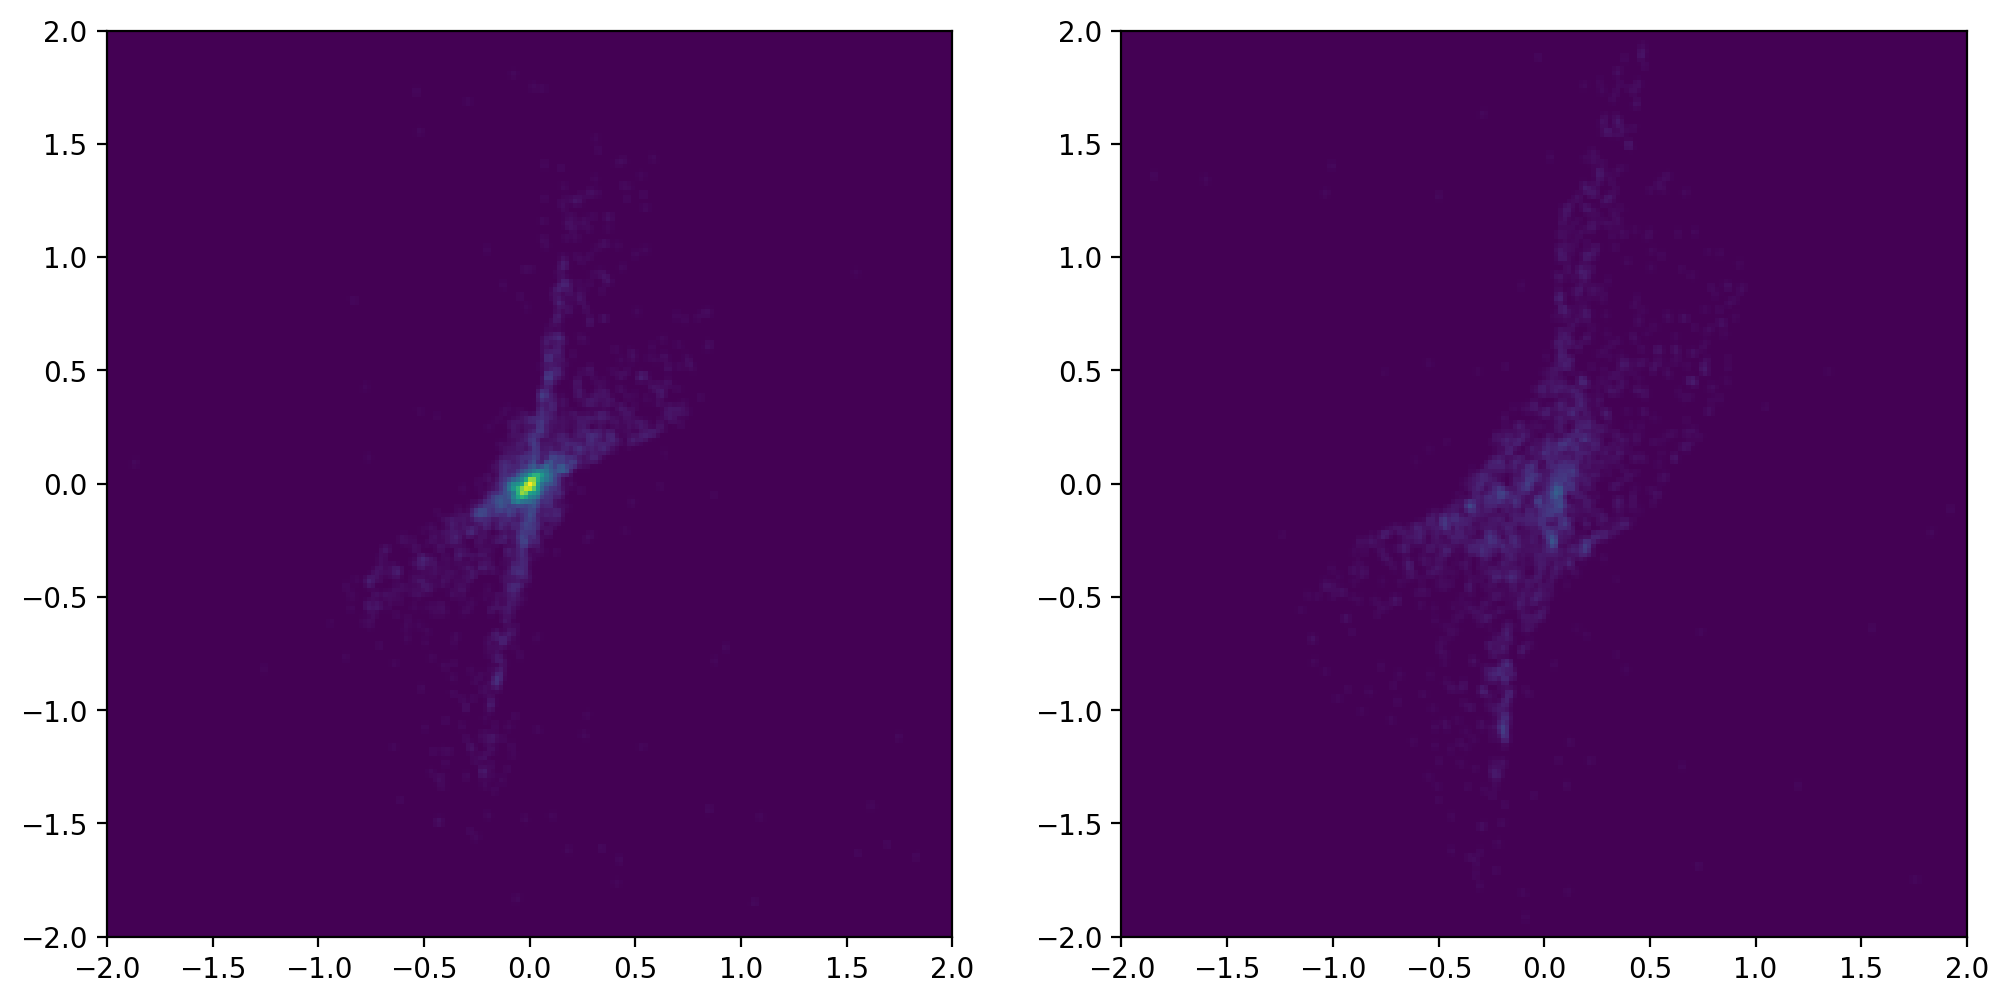

In [10]:
fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6),dpi=200)

extent = [-2,2,-2,2]
indx = np.nonzero(electrons.Data['momenta'][0]>12)[0]
h1 = chimera.density_2x(electrons.Data['coords'][1,indx],electrons.Data['momenta'][1,indx],
                        -electrons.Data['weights'][indx],extent,200,200)
h2 = chimera.density_2x(electrons.Data['coords'][2,indx],electrons.Data['momenta'][2,indx],
                        -electrons.Data['weights'][indx],extent,200,200)

ax1.imshow(h1.T,extent=extent,cmap=plt.cm.viridis,origin='lower',aspect='auto',vmax=2.5);
ax2.imshow(h2.T,extent=extent,cmap=plt.cm.viridis,origin='lower',aspect='auto',vmax=2.5);
